# Numerical Example 3 - Plotting only

# Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import random
import pandas as pd
import skfmm

from tqdm import tqdm
from torchinfo import summary
from curvature.curvatures import Diagonal, KFAC, EFB, INF

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Device Configuration

In [2]:
# PyTorch random number generator
torch.manual_seed(4321)

# Random number generations in other libraries
np.random.seed(4321)

# Device configuration
device = torch.device(1 if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda:1


# Model Specifications

In [3]:
# preparing velocity model
velocity_model = pd.read_csv('./otway2.csv',header=None)
velocity_model = velocity_model.T.values

In [4]:
xs = np.arange(201*0.008,213*0.008 + 0.008,0.008)
zs = np.arange(151*0.008,159*0.008 + 0.008,0.008)

nz, nx = velocity_model.shape

zmin = 0.0
zmax = zs[-1]

xmin = 0.0
xmax = xs[-1]

# creating grid, calculating reference traveltimes,
# and prepare list of grid points for training (X_star)

z = torch.linspace(zmin, zmax, nz)
x = torch.linspace(xmin, xmax, nx)
Z, X = torch.meshgrid(z, x)

deltaz = z[1] - z[0]
deltax = x[1] - x[0]

# point-source location
sz1 = torch.tensor([0.7])
sx1 = torch.tensor([1.0])

sz2 = torch.tensor([0.75])
sx2 = torch.tensor([1.10])

sz3 = torch.tensor([0.65])
sx3 = torch.tensor([0.9])

# number of training points
num_tr_pts = 5001

/home/izzatum/anaconda3/envs/AFWI/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# travel-time solution
phi = np.ones_like(velocity_model)
phi[int(sz1 // deltaz), int(sx1 // deltax)] = -1.
T_data = skfmm.travel_time(phi, velocity_model, dx=(deltaz, deltax))
T_data = torch.from_numpy(T_data).float()

# data
data_pts = np.hstack([torch.arange(0, nx, 60),])

data = T_data.reshape(-1, 1)[data_pts].requires_grad_(False).to(device)
Zd = Z.reshape(-1, 1)[data_pts]
Xd = X.reshape(-1, 1)[data_pts]

# training
selected_pts = np.random.choice(np.arange(Z.numel()), num_tr_pts, replace=False)
Zf = Z.reshape(-1, 1)[selected_pts]
Xf = X.reshape(-1, 1)[selected_pts]

# velocity
velmodel = torch.from_numpy(velocity_model).float()
velmodelf = velmodel.reshape(-1, 1)[selected_pts].requires_grad_(False).to(device)

# grid points for training
trainset = torch.hstack((Zf, Xf)).requires_grad_(True).to(device)

# grid points for data
dataset = torch.hstack((Zd, Xd)).to(device)

# grid points for prediction
testset = torch.hstack((Z.reshape(-1, 1), X.reshape(-1, 1))).to(device)

# params
params = {'vel':velmodelf, 'input':trainset, 'data_pts':dataset, 'data':data}

/tmp/ipykernel_1366206/2186407723.py:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  phi[int(sz1 // deltaz), int(sx1 // deltax)] = -1.


# Plot the velocity model with the source location

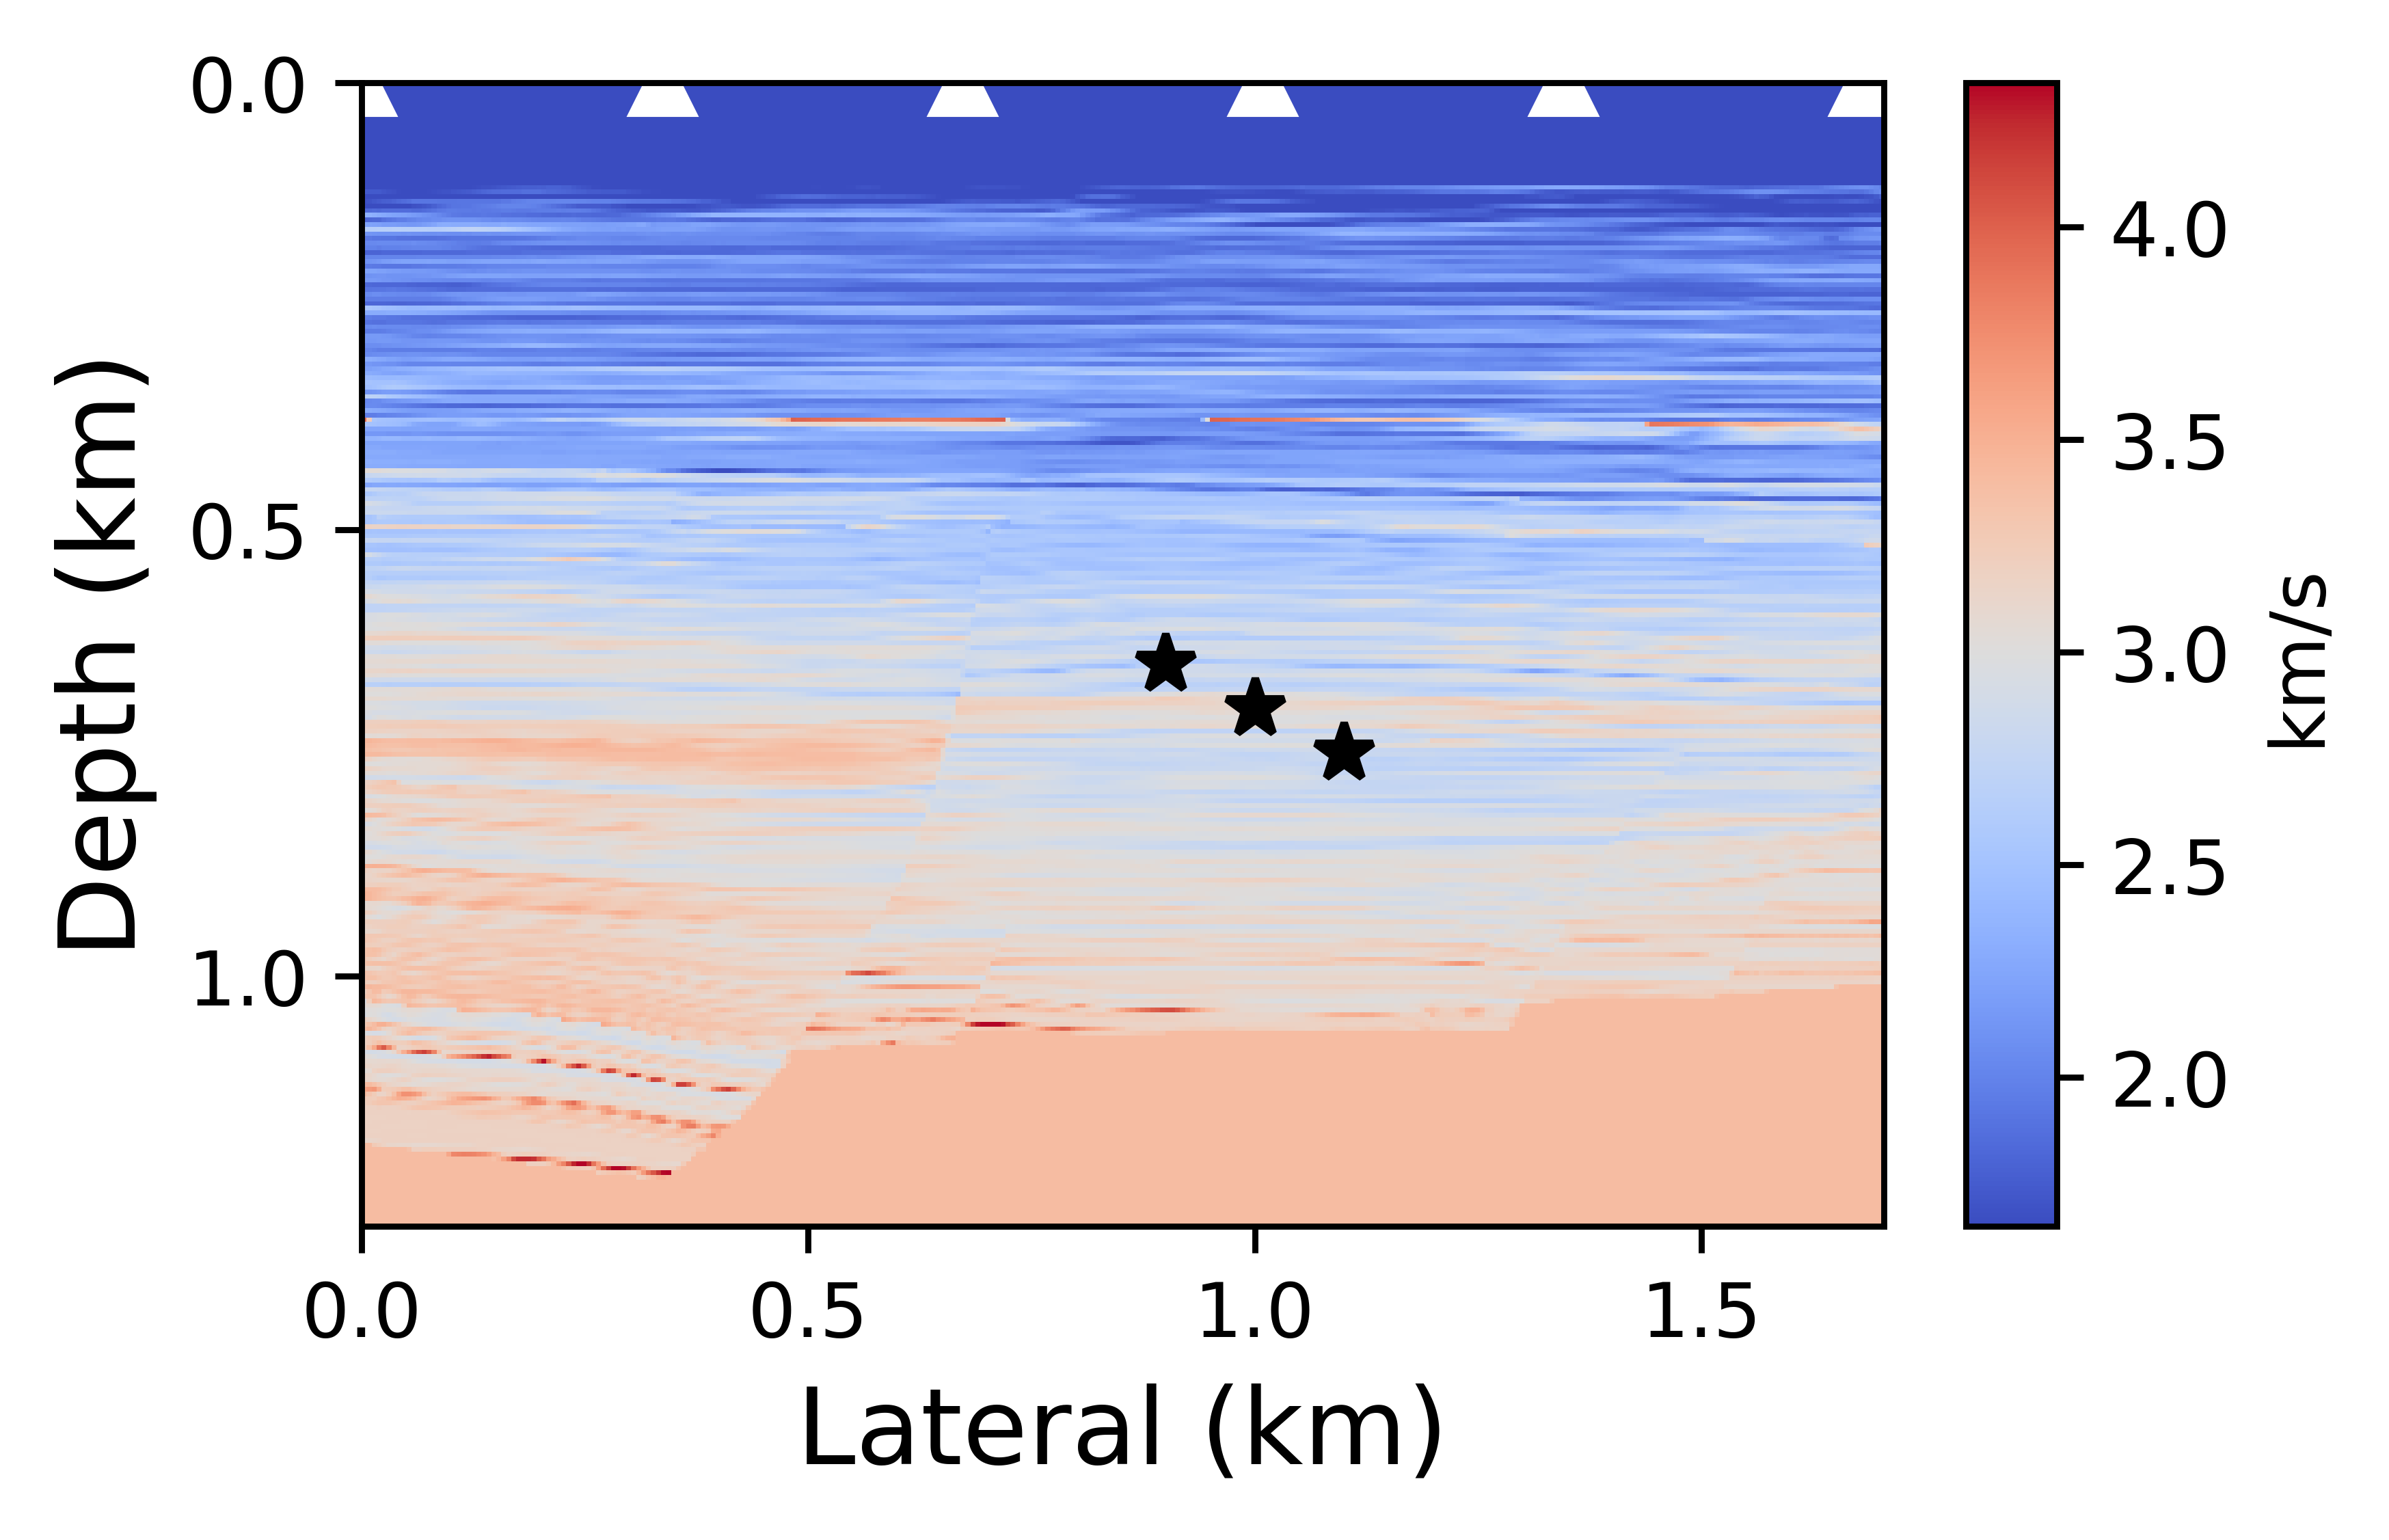

In [6]:
plt.style.use('default')

plt.figure(figsize=(4,4), dpi=800)

ax = plt.gca()
im = ax.imshow(velocity_model, aspect=1, extent=[xmin, xmax, zmax, zmin],
               cmap='coolwarm')

ax.plot(sx1, sz1, 'k*', markersize=8)
ax.plot(sx2, sz2, 'k*', markersize=8)
ax.plot(sx3, sz3, 'k*', markersize=8)
ax.plot(Xd, Zd, 'w^', markersize=8)

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s', size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./Figures/ex3_plot_vel.eps", format="eps", bbox_inches="tight", dpi=600)

In [7]:
ss1 = (1.0146, 0.7053)
ss2 = (1.0818, 0.8202)
ss3 = (0.9024, 0.6687)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


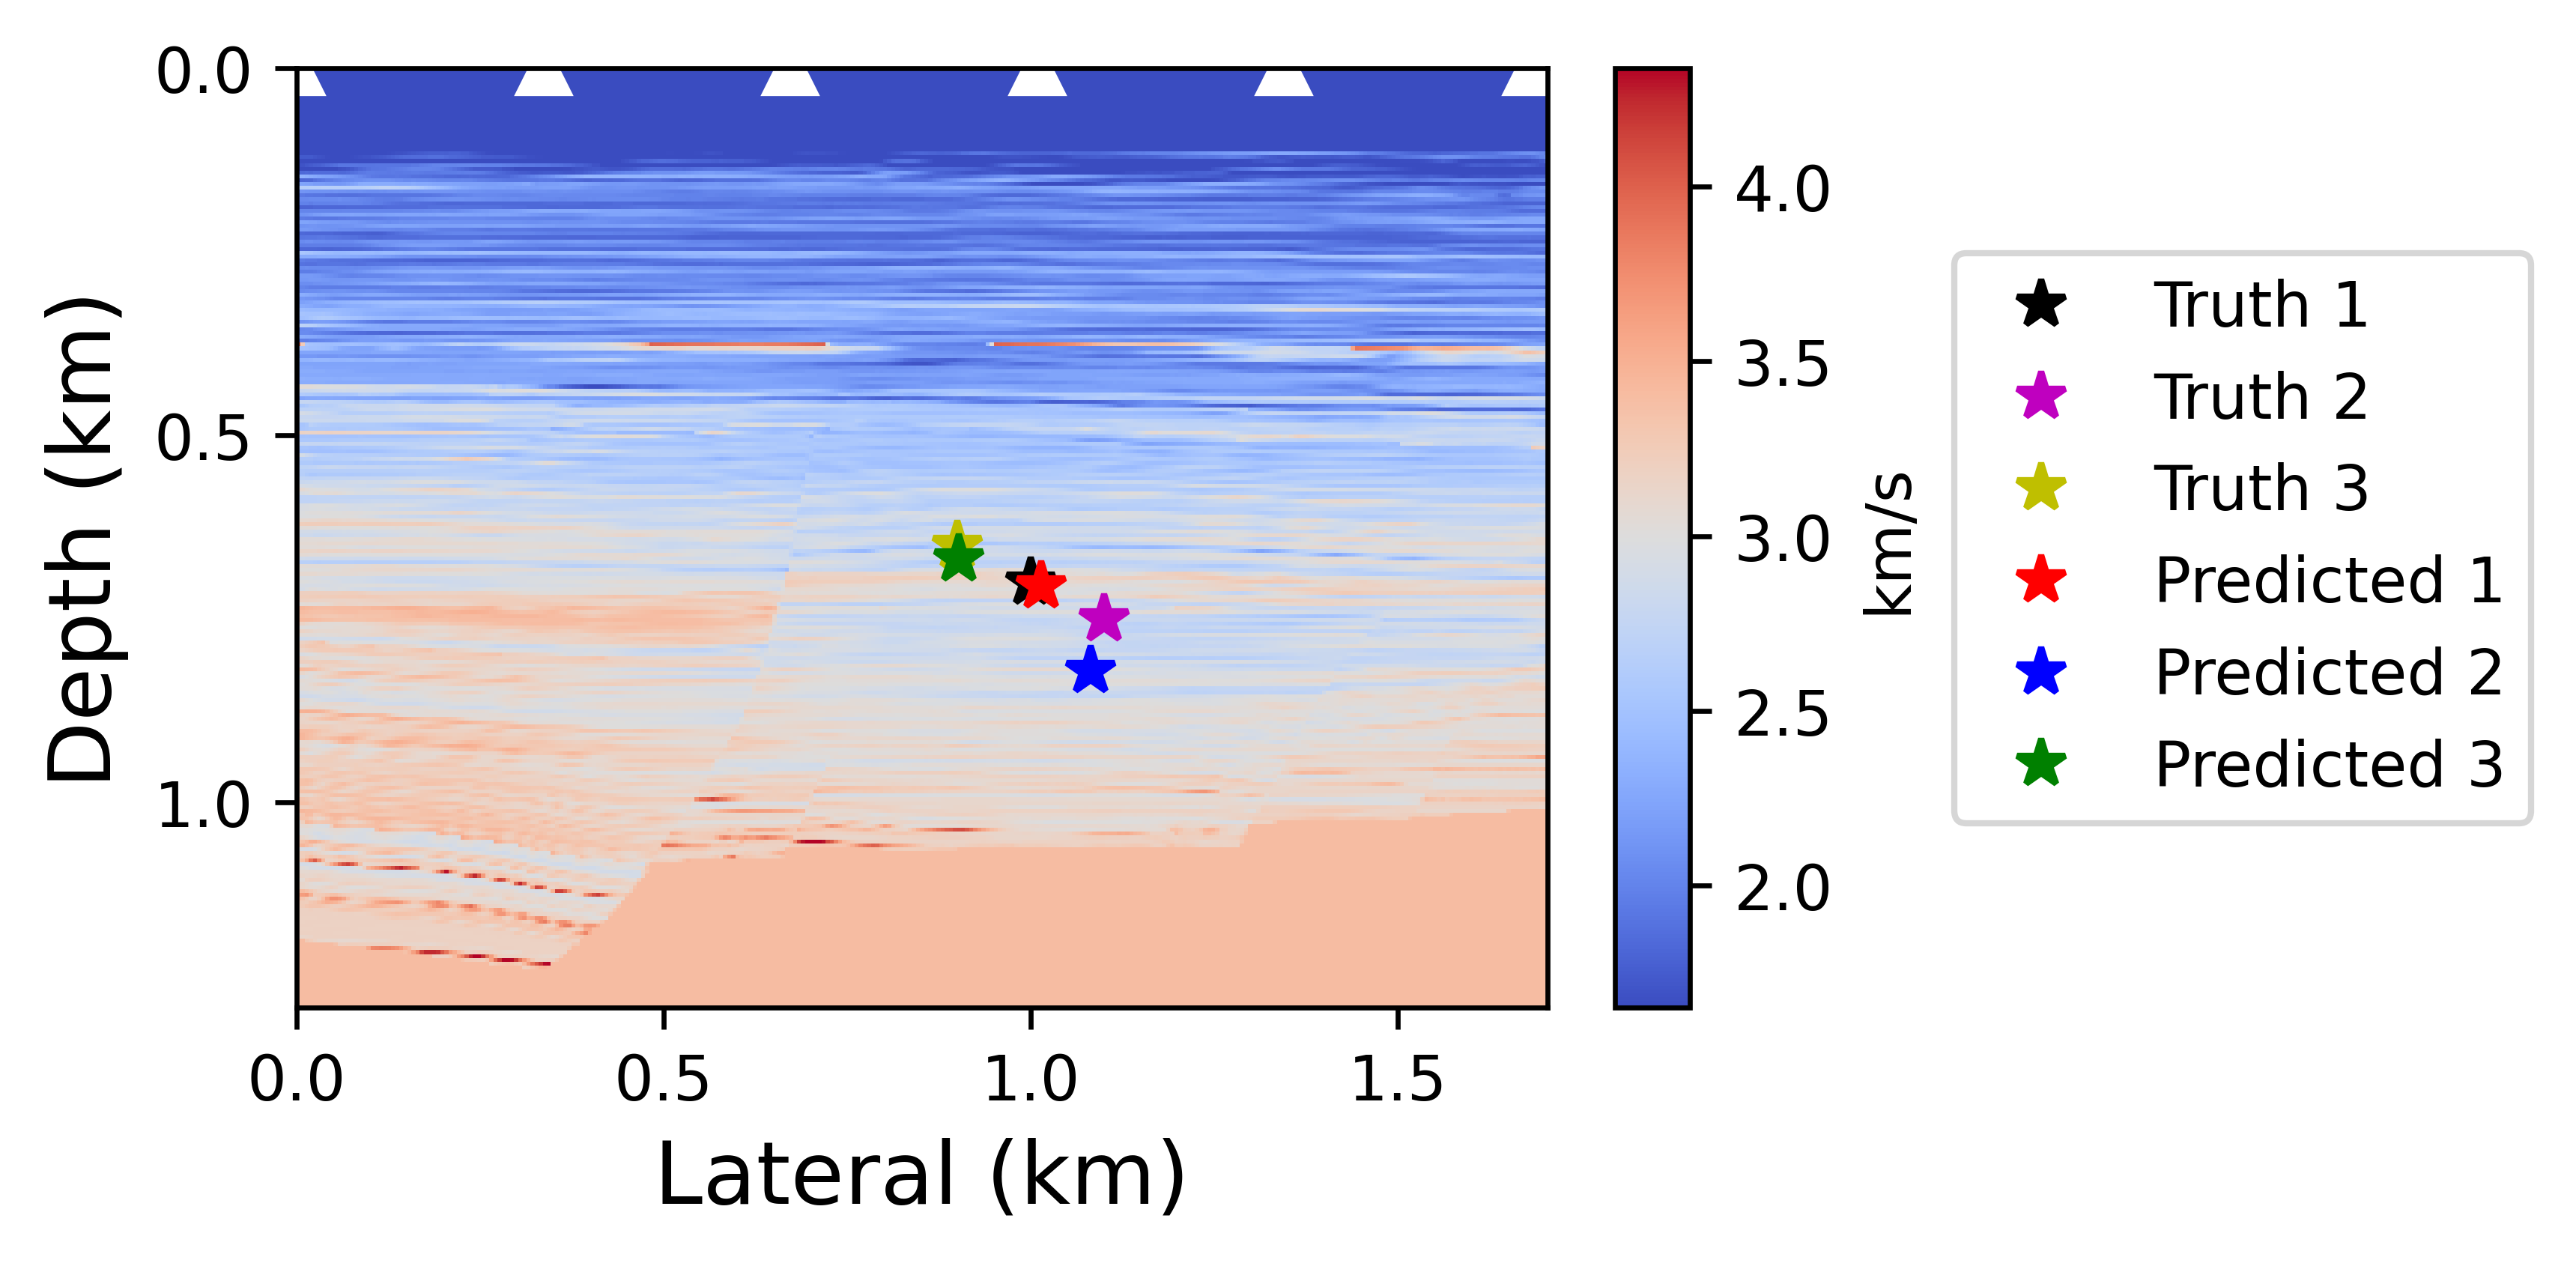

In [8]:
plt.style.use('default')

plt.figure(figsize=(4,4), dpi=600)

ax = plt.gca()
im = ax.imshow(velmodel, aspect=1, extent=[xmin, xmax, zmax, zmin],
               cmap='coolwarm')

ax.plot(Xd, Zd, 'w^', markersize=8)
ax.plot(sx1, sz1, 'k*', markersize=8, label='Truth 1')
ax.plot(sx2, sz2, 'm*', markersize=8, label='Truth 2')
ax.plot(sx3, sz3, 'y*', markersize=8, label='Truth 3')
ax.plot(ss1[0], ss1[1], 'r*', markersize=8, label='Predicted 1')
ax.plot(ss2[0], ss2[1], 'b*', markersize=8, label='Predicted 2')
ax.plot(ss3[0], ss3[1], 'g*', markersize=8, label='Predicted 3')

plt.xlabel('Lateral (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s', size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(f"./Figures/ex3_plot_hypo.eps", format="eps", bbox_inches="tight", dpi=600)